[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/usnistgov/AFL-agent/blob/23-documentation-improvements-v2/docs/source/tutorials/quickstart.ipynb)

# Quickstart

This notebook demonstrates how to use AFL-agent to analyze measurement data and identify different phases. We'll create a simple pipeline that:

1. Calculates derivatives of measurement data using Savitzky-Golay filtering
2. Computes similarity between measurements
3. Uses spectral clustering to group similar measurements into phases

We'll work with synthetic data that simulates two different types of signals - a flat background and a power law decay, both with added noise.


## Colab Setup

Only uncomment and run the next cell if you are running this notebook in Google Colab or if don't already have the AFL-agent package installed.

In [2]:
# !pip install git+https://github.com/usnistgov/AFL-agent.git

## Define Pipeline

In [1]:
from AFL.double_agent import *

with Pipeline() as clustering_pipeline:

        SavgolFilter(
            input_variable='measurement', 
            output_variable='derivative', 
            dim='x', 
            derivative=1
            )

        Similarity(
            input_variable='derivative', 
            output_variable='similarity', 
            sample_dim='sample',
            params={'metric': 'laplacian','gamma':1e-4}
            )
    
        SpectralClustering(
            input_variable='similarity',
            output_variable='labels',
            dim='sample',
            params={'n_phases': 2}
            )

The pipeline above consists of three operations:

1. `SavgolFilter`: Applies Savitzky-Golay filtering to calculate derivatives of the measurement data along the x-dimension. This helps identify changes in the signal shape.

2. `Similarity`: Computes pairwise similarity between measurements using their derivatives. It uses a Laplacian kernel with gamma=1e-4 to quantify how similar each measurement is to every other measurement.

3. `SpectralClustering`: Groups measurements into 2 phases based on their similarity scores. Measurements with high similarity will be grouped into the same phase.


## Load Input Data 

To test this pipeline, we need some data to analyze. We'll use a synthetic dataset containing measurements from a two-phase system. Each measurement represents a signal collected from a sample with different compositions of components A and B. For details on how this dataset was created, see the [Building xarray Datasets](../how-to/building_xarray_datasets.ipynb) tutorial.


In [2]:
from AFL.double_agent.datasets import example_dataset1
    
# Load the example dataset
ds = example_dataset1()
ds

TypeError: 'MultiplexedPath' object does not support the context manager protocol

We can plot the `measurements` data variable to see the two classes of measurements that we're going to try to separate

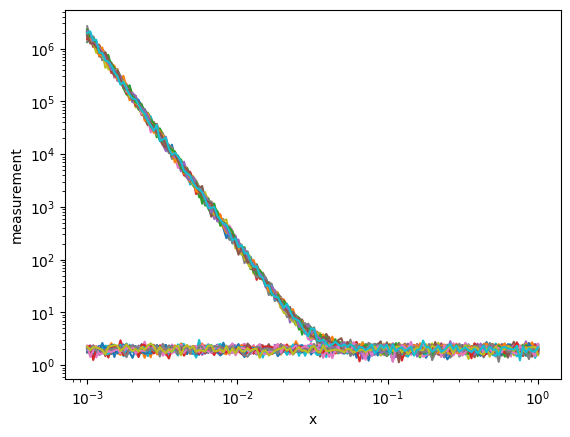

In [11]:
ds.measurement.plot.line(x='x',xscale='log',yscale='log',add_legend=False);

## Execute the Pipeline

Now we'll execute our clustering pipeline on the dataset. The pipeline will process the measurements, calculate derivatives, compute similarity between samples, and finally assign each measurement to one of the two phases.


In [17]:
ds_result = clustering_pipeline.calculate(ds)
ds_result

  0%|          | 0/3 [00:00<?, ?it/s]

<xarray.Dataset> Size: 184kB
Dimensions:      (sample: 50, x: 150, log_x: 250, sample_i: 50, sample_j: 50)
Coordinates:
  * x            (x) float64 1kB 0.001 0.001047 0.001097 ... 0.9114 0.9547 1.0
  * log_x        (log_x) float64 2kB -3.0 -2.988 -2.976 ... -0.0241 -0.01205 0.0
Dimensions without coordinates: sample, sample_i, sample_j
Data variables:
    measurement  (sample, x) float64 60kB 1.667e+06 1.417e+06 ... 1.736 2.463
    derivative   (sample, log_x) float64 100kB -3.262 -3.317 ... -0.2221 -0.2423
    similarity   (sample_i, sample_j) float64 20kB 1.0 0.9496 ... 0.9958 1.0
    labels       (sample) int64 400B 0 1 1 1 1 1 0 0 0 1 ... 0 0 0 1 1 0 1 1 1 1

In the resultant `xarray.Dataset`, we see a Data variable called `labels`. This is the pipelines attempt o group the data into two classes: Phase 0 or Phase1. 

Let's plot the data in two subplots to visualize the data that the pipeline puts in each of the classes. 

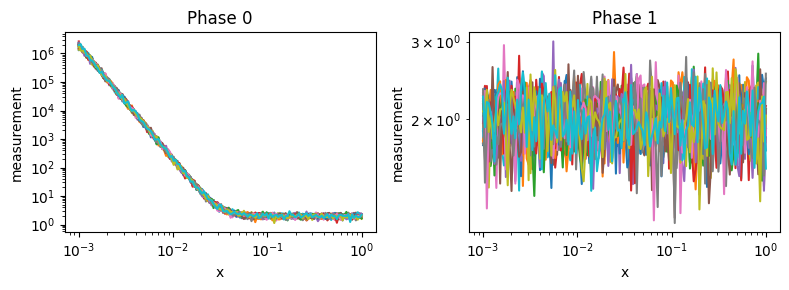

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(8,3))
for label,sub_ds in ds_result.groupby('labels'):
    sub_ds.measurement.plot.line(x='x',xscale='log',yscale='log',add_legend=False,ax=axes[label]);
    axes[label].set_title(f'Phase {label}')

fig.tight_layout()


We can see that the pipeline does an excellent job at separating the data!

## Conclusion

In this quickstart tutorial, we demonstrated how to use the clustering pipeline to automatically classify different phases in a dataset. We:
 
1. Started with a dataset containing multiple measurements with two distinct patterns
2. Applied the clustering pipeline to analyze and classify the data
3. Successfully separated the measurements into two distinct phases
 
The pipeline was able to automatically detect and group similar measurements, making it a powerful tool for analyzing phase transitions and other classification tasks in scientific data.
